## Spiking behaviour of the proposed neuron models

In [1]:
!pip install seaborn
!pip install --upgrade pandas

import seaborn as sns
from scipy.special import erf
import pylab
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from scipy.spatial import KDTree

Requirement already up-to-date: pandas in /home/nest/.local/lib/python3.7/site-packages (1.1.1)


In [99]:
# import multimeter and spikedetector data from CSVs
hh_neurons_scenario1 = pd.read_csv("dumps/17:24:28_hh-neurons_8ms_delay.csv", header = None).to_numpy()
hh_neurons_scenario2 = pd.read_csv("dumps/17:25:57_hh-neurons_9ms_delay.csv", header = None).to_numpy()




vm2 = pd.read_csv("vm0.csv", header = None).to_numpy()
vm3 = pd.read_csv("vm1.csv", header = None).to_numpy()
vm1 = pd.read_csv("vm2.csv", header = None).to_numpy()

sd2 = pd.read_csv("sd0.csv", names = np.arange(1,55), header = None).to_numpy()
sd3 = pd.read_csv("sd1.csv", names = np.arange(1,55), header = None).to_numpy()
sd1 = pd.read_csv("sd2.csv", names = np.arange(1,55), header = None).to_numpy()

ts = np.arange(0,len(hh_neurons_scenario1[0])*0.02, 0.02)

In [118]:
def spikes_hh(v, tau):
    
    title = ['alpha', 'beta', 'gamma']
    color = ['#688A08','#0B615E','#0B6138']
    
    
    fig, ax = plt.subplots(len(v[0]),len(v), sharex = True, figsize = (20,10))
    legend = []
    
    for i in range(len(v)):
        ax[0][i].set_title('tau = ' + str(tau[i]))
        for j, vm in enumerate(v[i]):
            legend.append(ax[j][i].plot(ts[:10000],vm[:10000], color = color[j], label = title[j])[0])
            #ax[j][i].set_title(title[j])
            ax[j][i].set_ylabel('V')
            ax[j][i].axvline(50,ls = '--', color = 'red')        
            ax[j][i].axvline(100,ls = '--', color = 'red')
            ax[j][i].axvline(150,ls = '--', color = 'red')        
       
            
    #plt.figlegend(legend[:4], title, loc = 'lower center', ncol=5, labelspacing=0. )
    fig.legend(handles=legend[:3], loc ='center right')    
    plt.xlabel('time in ms')   
    

In [146]:
from scipy.signal import argrelextrema, find_peaks

def get_spike_times(ts, V):
    spike_idx = find_peaks(V, height=(25., 150.), distance=7.)[0]
    return ts[spike_idx]

In [147]:
def nearest_spike_neighbour(v):
    
    
    fig, ax = plt.subplots(1, len(v), sharey = True)
    for j in range(len(v)):
        # phase lengths
        sta = get_spike_times(ts, v[j][0])
        pla = []
        for i in range(1, sta.shape[0]):
            pla.append(sta[i] - sta[i-1])

        stb = get_spike_times(ts, v[j][1])
        plb = []
        for i in range(1, stb.shape[0]):
            plb.append(stb[i] - stb[i-1])


        sta = np.reshape(sta, (sta.shape[0], 1))
        stb = np.reshape(stb, (stb.shape[0], 1))
        alpha_tree = KDTree(sta)
        nn_dist, nn_idx = alpha_tree.query(stb, 1)



        ax[j].plot(stb[1:], nn_dist[1:], color = '#0B615E')
        ax[j].axhline(1,ls='--', color = "red")
        ax[j].set_xlabel("t")
        
    ax[0].set_ylabel("spike_dist")
    fig.suptitle("Distance from alphas spikes to their nearest neighbors in betas spikes", fontsize=16)    

   

In [148]:
# Fig 5. A) Raster plot of 300 neurons randomly selected among the 3 populations
def raster_plot(s=[], case = 0):

    plt.rcParams["figure.figsize"] = (20,10)
    for i in range(s.shape[0]):
        
        if i % 100 >= 80:
            pylab.plot(s[i], [i]*len(s[i]), ".", color="gray", markersize=2)
        else:
            pylab.plot(s[i], [i]*len(s[i]), ".", color="black", markersize=2)


    plt.axhspan(0,80,facecolor="lightblue",alpha=0.2, label = "alpha")
    plt.axhspan(80,100,facecolor="lightblue",alpha=0.1)
    plt.axhspan(100,180,facecolor="lightgreen",alpha=0.2, label = "beta")
    plt.axhspan(180,200,facecolor="lightgreen",alpha=0.1)
    plt.axhspan(200,280,facecolor="blue",alpha=0.2, label = "gamma")
    plt.axhspan(280,300,facecolor="blue",alpha=0.1)
    
    pylab.title("Raster plot Case " + str(case))
    pylab.xlabel("time in ms")
    pylab.ylabel("neuron ID")
    pylab.legend()
    pylab.show()

In [149]:
def plot_spikes(s=[], case = 0):
    plt.rcParams["figure.figsize"] = (20,10)
    pylab.figure()
    i1 = np.random.randint(100)
    i2 = np.random.randint(100, 200)
    i3 = np.random.randint(200, 300)
    
    ts1 = s[i1]
    ts1 = ts1[~np.isnan(ts1)]
    ts2 = s[i2]
    ts2 = ts2[~np.isnan(ts2)]
    ts3 = s[i3]
    ts3 = ts3[~np.isnan(ts3)]

    tree1 = KDTree(np.reshape(ts1, (len(ts1), 1)))
    tree2 = KDTree(np.reshape(ts2, (len(ts2), 1)))
    
    nn_dist_12, _ = tree1.query(np.reshape(ts2, (len(ts2), 1)))
    nn_dist_13, _ = tree1.query(np.reshape(ts3, (len(ts3), 1)))
    nn_dist_23, _ = tree2.query(np.reshape(ts3, (len(ts3), 1)))
    
   
    pylab.plot(ts2[1:], nn_dist_12[1:], color = "red")
    pylab.plot(ts3[1:], nn_dist_13[1:], color = "darkblue", alpha = 0.7)
    pylab.plot(ts3[1:], nn_dist_23[1:], color = "blue", alpha = 0.7)
    
    pylab.plot(ts1, np.full((len(ts1)), 1), ".")
    pylab.plot(ts2, np.full((len(ts2)), 1), ".")
    pylab.plot(ts3, np.full((len(ts3)), 1), ".")
    
    pylab.title("Spike distances between neurons Case" + str(case))
    pylab.legend(["alpha-beta", "alpha-gamma", "beta-gamma"])
    pylab.xlabel("t")
    pylab.ylabel("Distance")
    pylab.show()

In [150]:
def coinc_hists(v=[], case = 0):
    
    start_idx = 100
    end_idx = 400
    threshold = .008
    
    offsets = np.arange(-80, 80, 2)
    hist12 = np.empty((300, len(offsets)))
    hist13 = np.empty((300, len(offsets)))
    hist23 = np.empty((300, len(offsets)))
    
    for sample in range(300):
    
        idx1 = np.random.randint(100)
        idx2 = np.random.randint(100, 200)
        idx3 = np.random.randint(200, 300)

        Vms1 = v[idx1]
        Vms2 = v[idx2]
        Vms3 = v[idx3]


        for i, offset in enumerate(offsets):
            diff12 = Vms1[start_idx : end_idx] - Vms2[start_idx + offset: end_idx + offset]
            diff13 = Vms1[start_idx : end_idx] - Vms3[start_idx + offset: end_idx + offset]
            diff23 = Vms2[start_idx : end_idx] - Vms3[start_idx + offset: end_idx + offset]
            hist12[sample, i] = len(diff12[np.abs(diff12) < threshold])
            hist13[sample, i] = len(diff13[np.abs(diff13) < threshold])
            hist23[sample, i] = len(diff23[np.abs(diff23) < threshold])
            
    hist12_mean = np.mean(hist12, axis=0)
    hist13_mean = np.mean(hist13, axis=0)
    hist23_mean = np.mean(hist23, axis=0)
    
    fig, ax = plt.subplots(1,3, sharey = True)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    
        
    ax[0].set_title("alpha & beta Case " + str(case))
    ax[0].bar(offsets, hist12_mean, color = ["#0B610B","#088A08"], width=2.0)
    ax[0].axvline(x=0, color = "red")
  
    ax[1].set_title("alpha & gamma Case " + str(case))
    ax[1].bar(offsets, hist13_mean, color = ["#0B6138","#088A68"], width=2.0)
    ax[1].axvline(x=0, color = "red")


    ax[2].set_title("beta & gamma Case" + str(case))
    ax[2].bar(offsets, hist23_mean, color = ["#688A08","#86B404"], width=2.0)
    ax[2].axvline(x=0, color = "red")


    pylab.show()


In [151]:
def firing_hists(s=[], case=0):
    
    plt.rcParams["figure.figsize"] = (20,10)

    ts1 = []      
    ts2 = []      
    ts3 = []    
    
    for i in range(100):
        ts1.append(s[i])
        ts2.append(s[i+100])
        ts3.append(s[i+200])
        
    ts1 = np.hstack(ts1)
    ts2 = np.hstack(ts2)
    ts3 = np.hstack(ts3)
    
    bin_size = 1.
    bins = np.arange(0, 1000, bin_size)
    
    hist1, _ = np.histogram(ts1, bins=bins)
    hist2, _ = np.histogram(ts2, bins=bins)
    hist3, _ = np.histogram(ts3, bins=bins)
    
    bin_means = (bins - bin_size / 2)[1:]
    
    pylab.figure()
    pylab.plot(bin_means, hist1, color = "#688A08")
    pylab.plot(bin_means, hist2, color = "#0B615E")
    pylab.plot(bin_means, hist3, color = "lightblue")
    pylab.legend(["alhpa", "beta", "gamma"])
    pylab.xlabel("t")
    pylab.ylabel("PTSH")
    pylab.title("Firing histogram of each subpopulation Case " + str(case))
    pylab.show()

In [152]:
def violin_plots(v):
    
    plt.rcParams["figure.figsize"] = (20,10)
 
    pal = sns.cubehelix_palette(len(v)*3, rot=-.5, dark=.3)
    
    data = []
    for vm in v:
        
        idx1 = np.random.randint(100)
        idx2 = np.random.randint(100,200)
        idx3 = np.random.randint(200,300)

        m1 = vm[idx1]
        m2 = vm[idx2]
        m3 = vm[idx3]
    

        data.append(m1-m2)
        data.append(m1-m3)
        data.append(m2-m3)
    
    ax = sns.violinplot(data=data, palette=pal)
    
    ax.axhline(0, ls='--', color="red")
    
    ax.set_xticklabels(['alpha-beta','alpha-gamma','beta-gamma']*len(v))
    
    ax.axvspan(-.5,2.5,facecolor="lightblue",alpha=0.2, label = "case 1")
    ax.axvspan(2.5,5.5,facecolor="lightgreen",alpha=0.2, label = "case 2")
    ax.axvspan(5.5,8.5,facecolor="blue",alpha=0.2, label = "case 3")
    
    ax.legend()
  

### Synchronization behaviour of single interconnected HH - Neurons  

#### 1.Three HH cells in a circuit with reciprocal delayed synaptic connections with constant axonal delays

- TODO: Introduction (results, goals)

In this first scenario three HH - neurons are arranged in a circuit with reciprocal delayed synaptic connections. Apart from their interconnection all neurons are in a toinic firing mode with a natural period of 14.7ms due to an intracellular constant stimulation of 10 $\mu$A/cm$^2$. 
Further, the conduction delays are set to 8ms and the initial phase of each neuron is randomly chosen.

![alt text](img/exp1.png "Experiment 1")

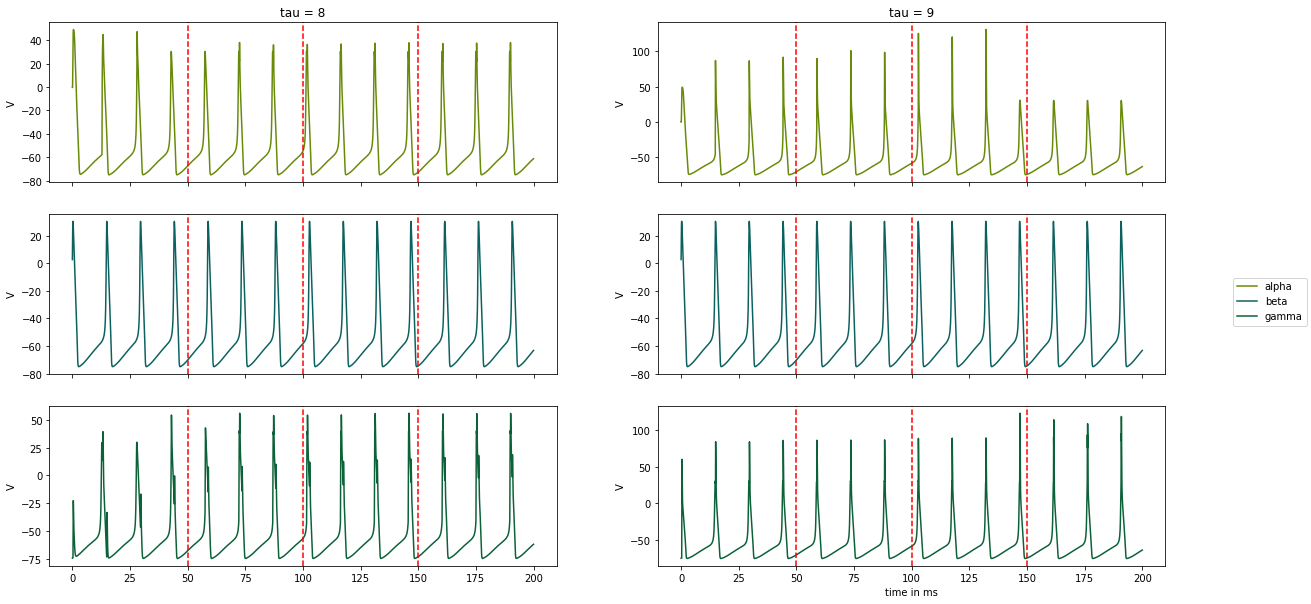

In [153]:
spikes_hh([hh_neurons_scenario1, hh_neurons_scenario2], [8,9])

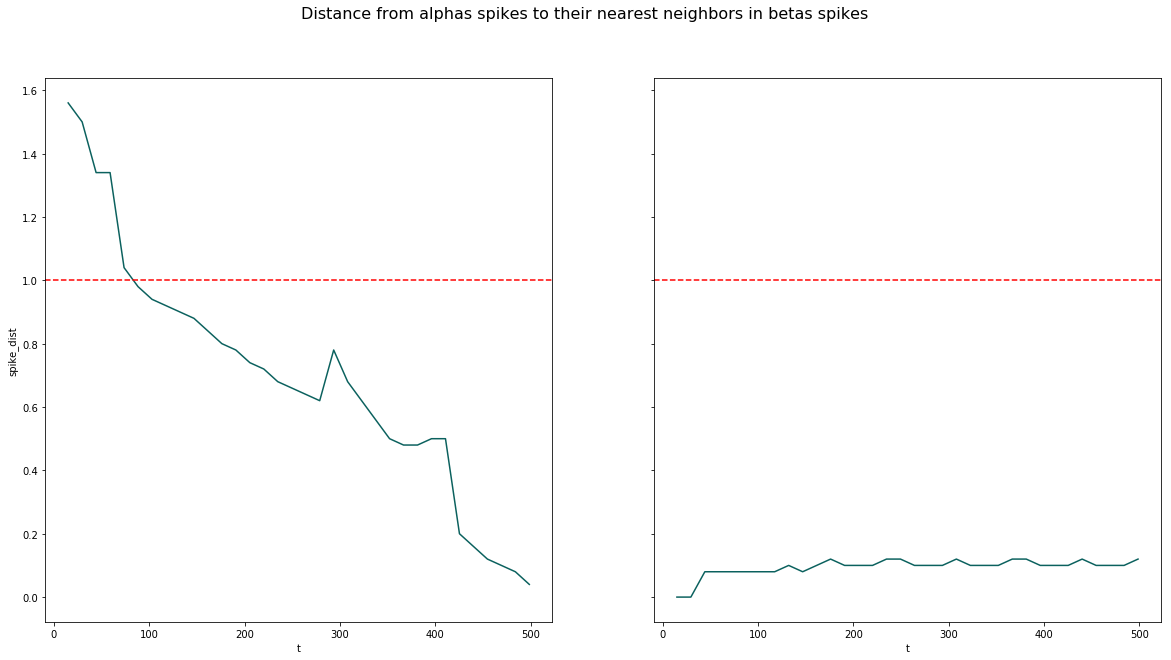

In [154]:
nearest_spike_neighbour([hh_neurons_scenario1,hh_neurons_scenario2])

#### 2. Three HH cells in a circuit with reciprocal delayed synaptic connections with varying axonal delays among the connections

Two scenarios were studied: one in which the neurons were directly coupled via excitatory synapses (dashed line) and a second one in which the 2 neurons interacted through a relay cell also in an excitatory manner (solid line).


In [14]:
# TODO: Different axonal delays, Fig 2????

#### 3. Three HH cells in a circuit with reciprocal delayed synaptic connections with excitatory and inhibitory interconnections

Robust zero lag synchrony among the outer neurons was also observed when the synaptic interaction between the cells was inhibitory instead of excitatory.

In [15]:
# TODO: Excitatory and inhibitory connections

#### 4. Three HH cells in a circuit with reciprocal delayed synaptic connections with delays displayed as a $\gamma$ distribution

We modeled the dispersion of axonal latencies by assuming that individual temporal delays of the arrivals of action
potentials (i.e., latency times) follow a $\gamma$ distribution

- mean delays between 3 and 10 ms


In [16]:
# TODO: distribution for delays

#### 5. Three HH cells in a circuit with reciprocal delayed synaptic connections with delays displayed as different $\gamma$ distributions per connection

We modeled the dispersion of axonal latencies by assuming that individual temporal delays of the arrivals of action
potentials (i.e., latency times) follow a $\gamma$ distribution

- mean delays between 3 and 10 ms



In [17]:
#TODO: Fig 4

### Synchronization behaviour of Populations of Distant Neurons

To check whether zero time lag-correlated firing is induced among neurons in different populations, we built 3 large networks of sparsely connected excitatory and inhibitory integrate and fire (IAF) neurons.

Each population was composed of 4,175 IAF neurons from which
80% were excitatory and 20% inhibitory. Each neuron received a synapse from 10% of randomly selected cells inside its population and from 0.25% from the excitatory class of the neighboring populations.

We interconnected the 3 populations following the topology of the network motif under study, i.e., the mutual relaying of activities of 2 external populations onto an intermediate pool of relay neurons. Additionally, we checked two other cases: one, with no connections between the different populations at all and another one with direct connections between the outer populations.

#### 1. Three networks without long - range interpopulation connections 


![alt text](img/case2.jpeg "Case 1")

In the first case all 3 networks are initialized without the long-range interpopulation connections. Only the recurrent local connections and the Poissonian external background were active and thus responsible for any dynamics in the stand-alone networks.
<br>
<br>
Consequently, each population initially exhibited spiking of their
neurons in an incoherent and unsynchronized fashion.



#### 2. Three networks with long - range interpopulation connections

![alt text](img/case3.jpeg "Case 1")

In the second case the three populations are interconnected following the topology of the network motif under study, i.e., the mutual relaying of activities of 2 external populations onto an intermediate pool of relay neurons.

Once the long-range synapses were activated, we observed that the firing of the neurons organized toward the collective synchrony of the outer populations.

#### 3. Three networks long - range interpopulation connections between the outer populations

![alt text](img/case1.jpeg "Case 1")

To determine the role of the relay cells in shaping the synchronization among cells belonging to the remote
neuronal networks we designed the following control experiment. We investigated the neuronal dynamics obtained under exactly the same conditions as in the former approach with the only variation that this time the 2 outer
networks interacted directly.

The sole change of the topology of the connections meant that networks 1 and 3, even if engaged in oscillations with similar characteristics as before, no longer synchronized their spikes at zero lag.

### Results

#### 1. Raster plot 

300 neurons are randomly selected among the 3 populations (neurons 1–100 are from population 1, 101–200 from population 2, and 201–300 from population 3). The top 20 neurons of each subpopulation (plotted in gray) are
inhibitory, and the rest are excitatory (black).

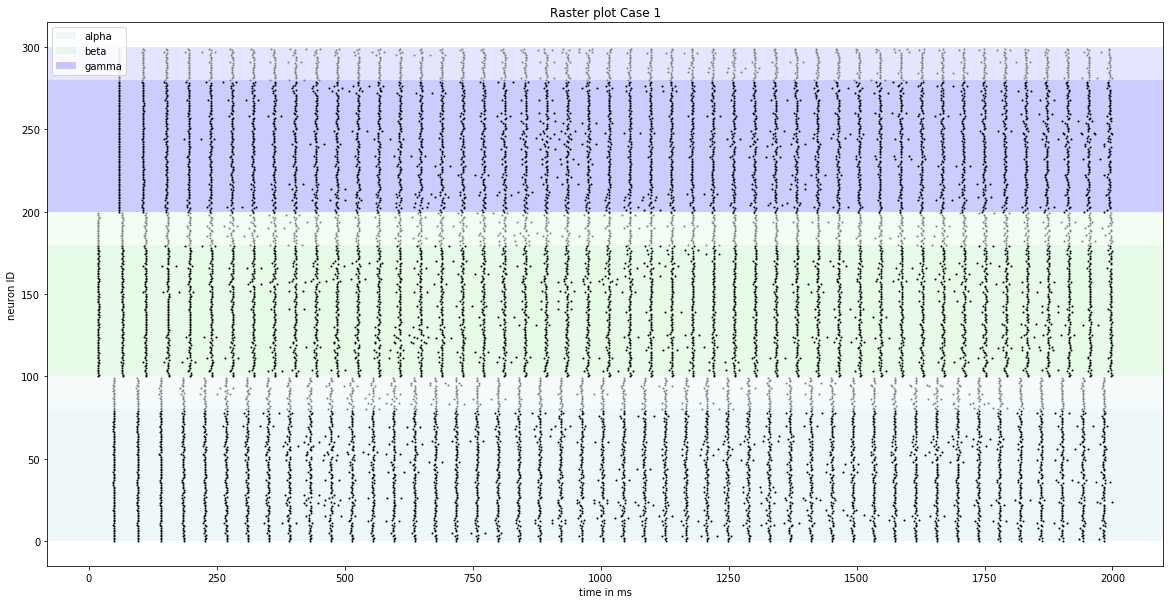

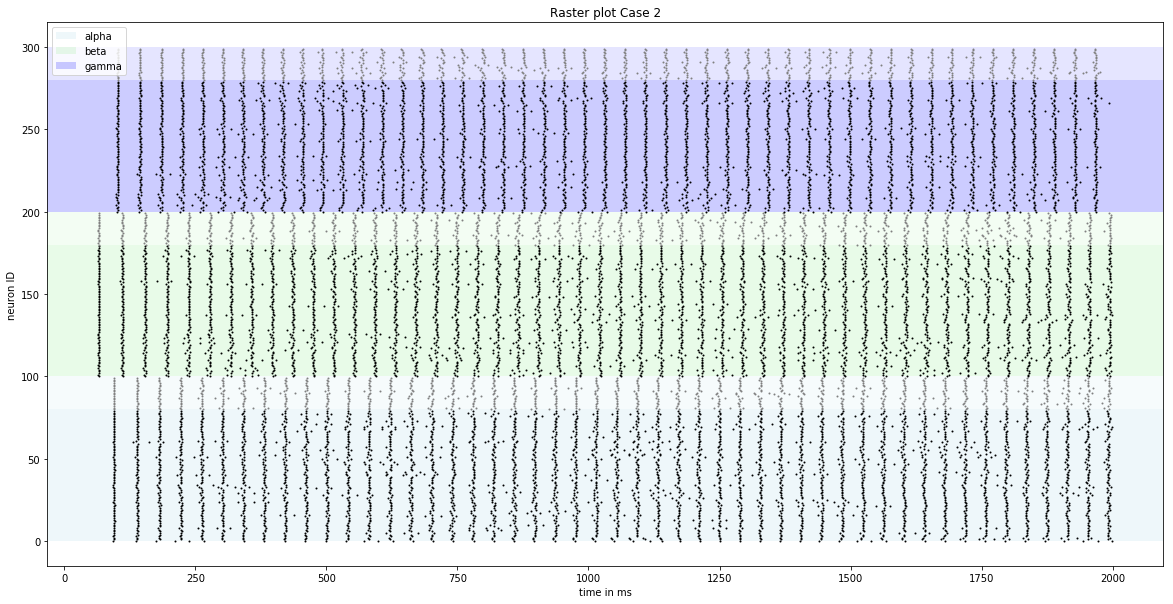

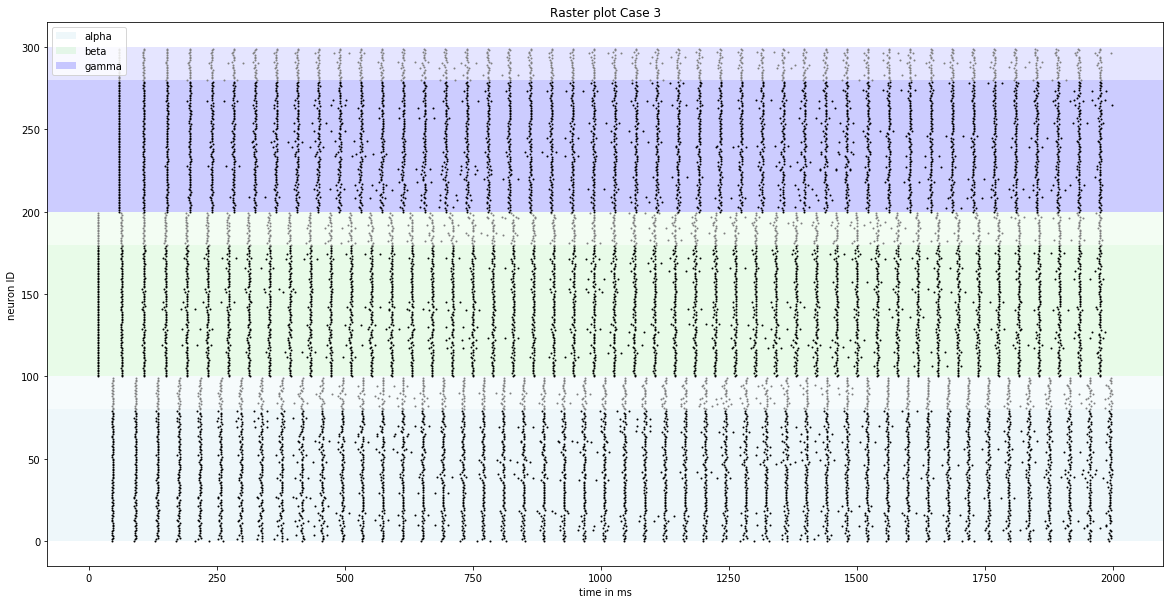

In [18]:
raster_plot(sd1, 1)
raster_plot(sd2, 2)
raster_plot(sd3, 3)

#### 2. Averaged cross-correlogram

We randomly selected three neurons (one from each of the three populations) and computed for each pair of neurons belonging to different populations the histogram of coincidences (bin size of 2 ms) as a function of the time shift of one of the spike trains. We computed the cross-correlograms within the time window ranging from 500 to 1,000 ms to avoid the transients toward the synchronous state. The procedure was repeated 300 times to give rise to the estimated averaged distributions of coincidences.

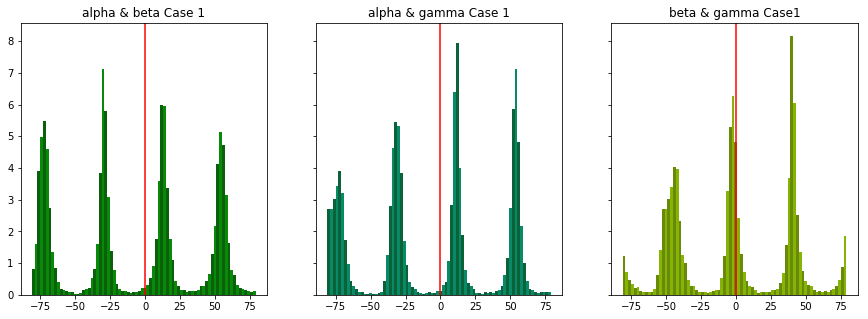

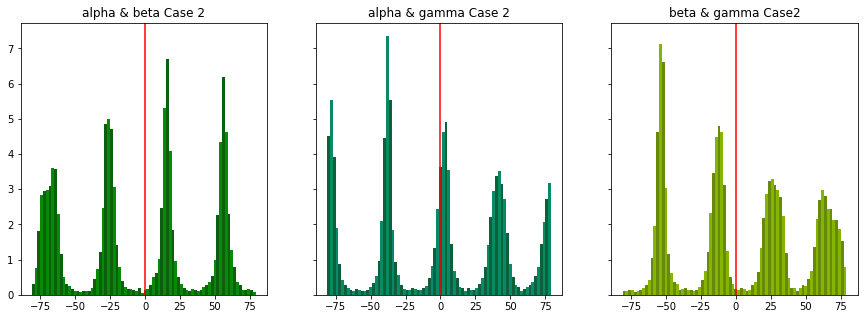

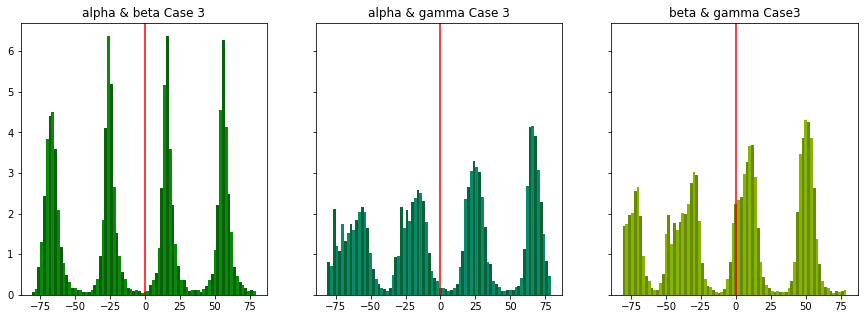

In [19]:
coinc_hists(vm1,1)
coinc_hists(vm2,2)
coinc_hists(vm3,3)

#### Firing histogram of each subpopulation of 100 randomly selected neurons

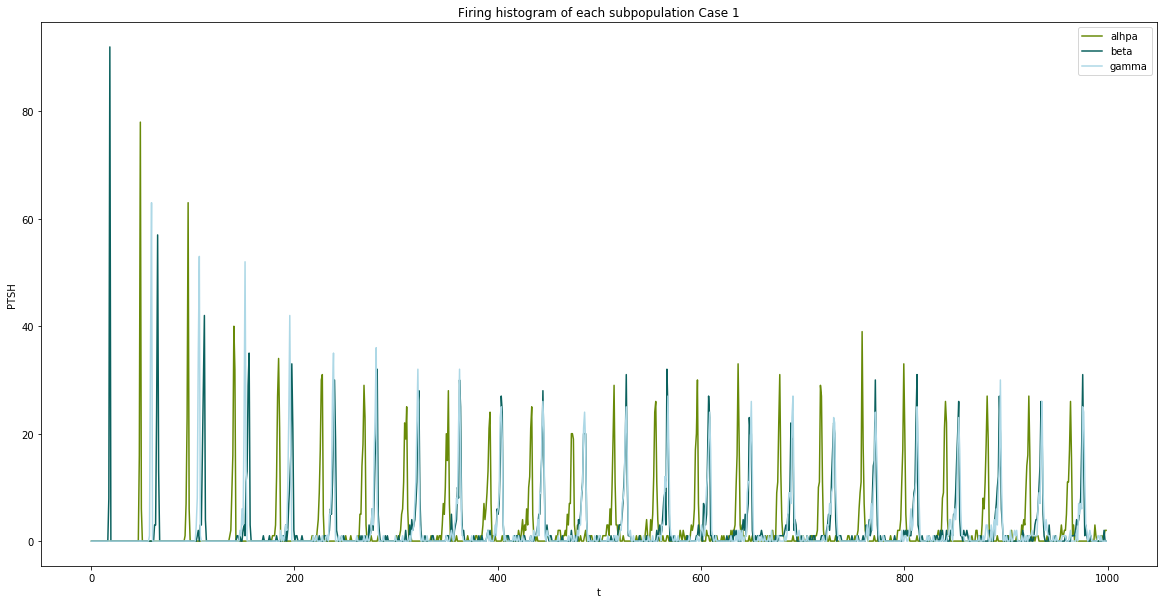

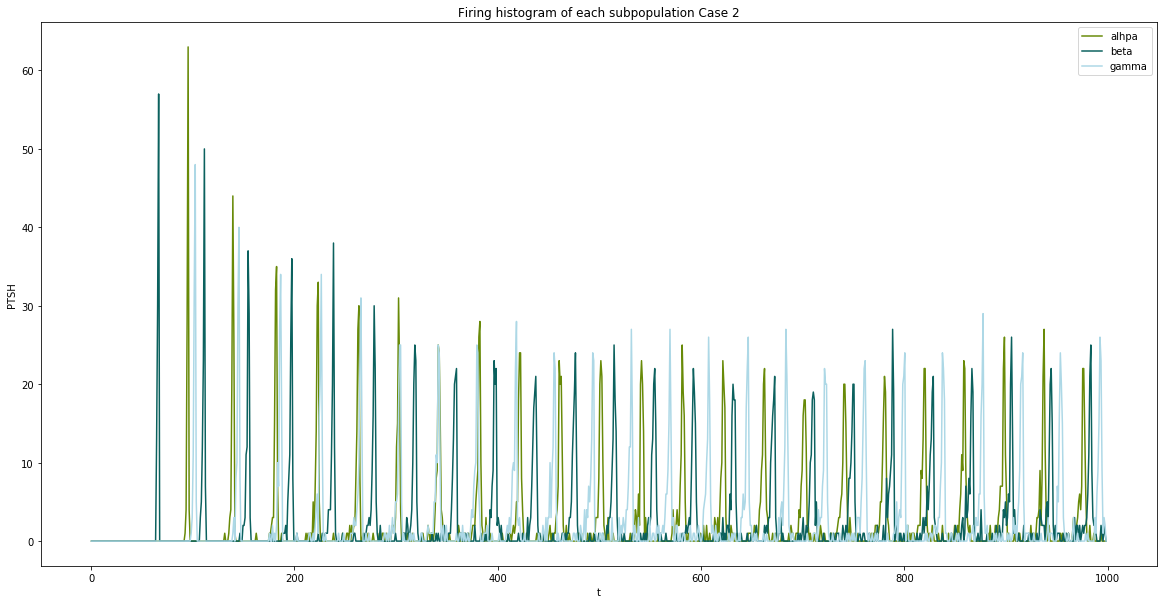

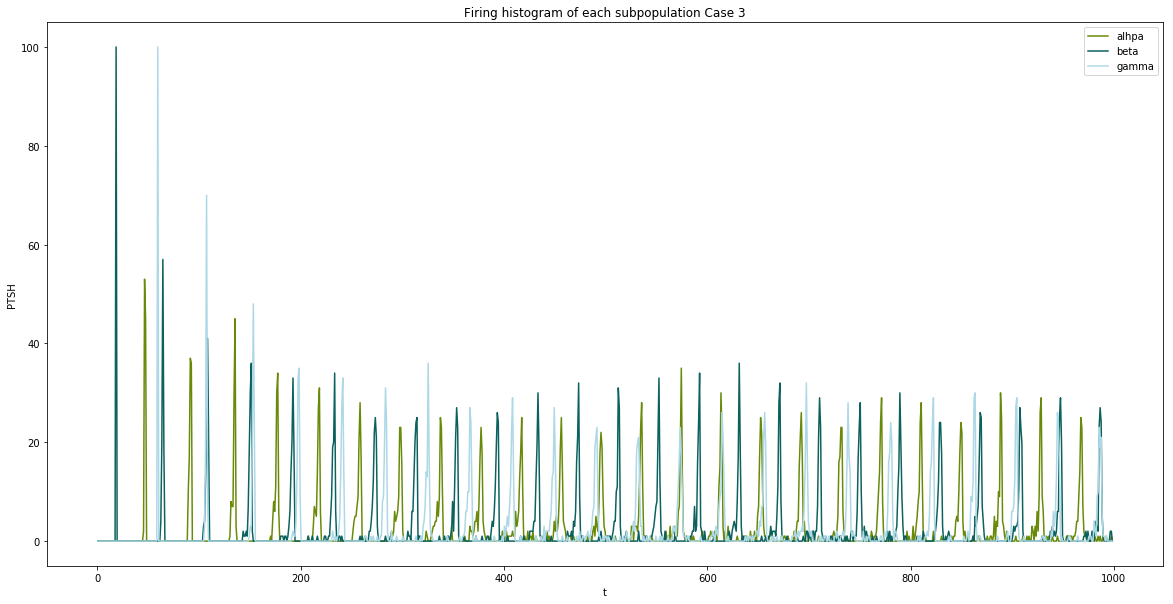

In [20]:
firing_hists(sd1,1)
firing_hists(sd2,2)
firing_hists(sd3,3)

### Summary

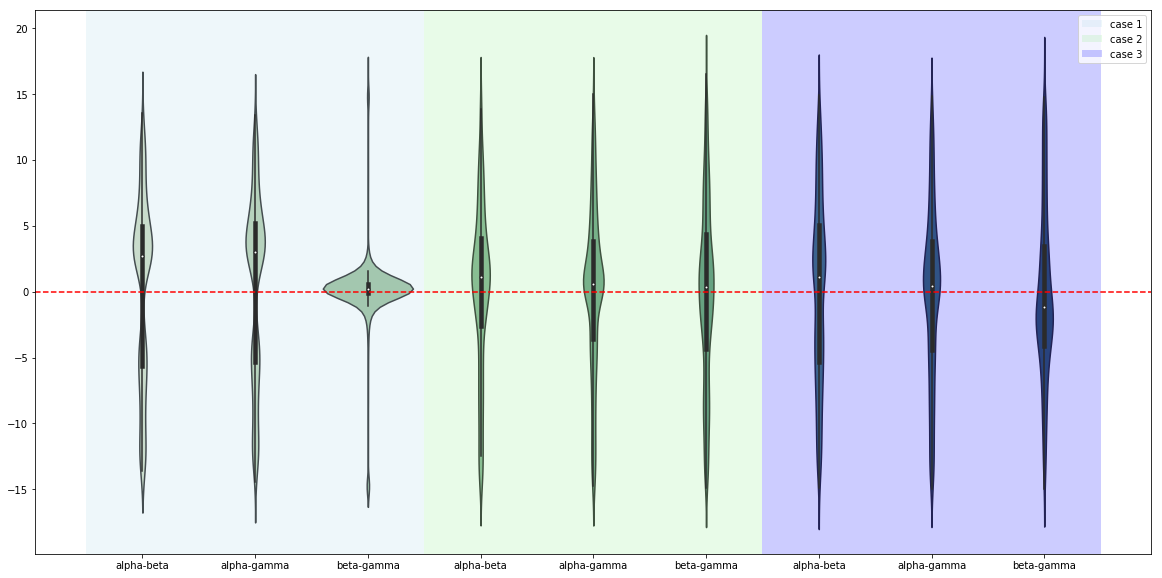

In [21]:
violin_plots([vm1,vm2,vm3])